In [ ]:
## Working but not correct output check Ml_Proj2_workingtillvisual.ipynb in sggs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.preprocessing import LabelEncoder
import numpy as np
from skimage.color import rgb2lab

In [ ]:
# Determine device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import numpy as np
import torch
from skimage.color import rgb2lab

# Function to scale images to [0, 255]
def scale_to_255(x):
    return x * 255

def rgb_to_ab(images):
    a_channels = []
    b_channels = []
    for img in images:  # Iterate through each image in the batch
        img = img.permute(1, 2, 0).cpu().numpy()  # Change to HWC format and move to CPU
        lab_image = rgb2lab(img)  # Convert to CIE-Lab

        # Normalize L, a, and b channels
        L_channel = lab_image[:, :, 0] / 100.0  # Normalize L channel
        a_channel = (lab_image[:, :, 1] + 128) / 255.0  # Normalize a channel
        b_channel = (lab_image[:, :, 2] + 128) / 255.0  # Normalize b channel

        # Collect normalized channels
        a_channels.append(a_channel)
        b_channels.append(b_channel)

    # Stack the a and b channels and convert to tensors
    return (
        torch.tensor(np.stack(a_channels), dtype=torch.float32).to(device),  # Move to device
        torch.tensor(np.stack(b_channels), dtype=torch.float32).to(device)   # Move to device
    )

In [ ]:
# CIFAR10 Dataset Loader
def load_cifar10_dataset(batch_size=8, num_workers=2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet/DenseNet input size
        transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
        transforms.Lambda(scale_to_255),  # Scale to [0, 255]
    ])

    # Load the CIFAR-10 dataset
    train_set = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)

    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
# Define the colorization model (same as before)
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Pre-trained ResNet50 encoder
        self.encoder_resnet = nn.Sequential(
            *list(models.resnet50(weights='IMAGENET1K_V1').children())[:-2]
        )

        # Pre-trained DenseNet121 encoder
        self.encoder_densenet = nn.Sequential(
            *list(models.densenet121(weights='IMAGENET1K_V1').children())[:-1]  # Use all layers except the classifier
        )

        # Pooling layer to downsample DenseNet output to 7x7
        self.downsample_densenet = nn.AdaptiveAvgPool2d((7, 7))

        # Fusion Blocks
        self.fusion_block1 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block2 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block4 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder Blocks
        self.decoder_block1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block5 = nn.Sequential(
            nn.Conv2d(256, 2, kernel_size=3, padding=1),
            nn.Tanh()  # Use Tanh to match output range [-1, 1]
        )

    def forward(self, x):
        # Encoder
        x_resnet = self.encoder_resnet(x)  # ResNet output
        x_densenet = self.encoder_densenet(x)  # DenseNet output
        x_densenet = self.downsample_densenet(x_densenet)  # Downsample DenseNet output

        # Fusion Blocks
        fb1_input = torch.cat([x_resnet, x_densenet], dim=1)  # 2048 + 1024
        fb1_output = self.fusion_block1(fb1_input)

        fb2_input = torch.cat([fb1_output, fb1_output], dim=1)  # Use previous output only
        fb2_output = self.fusion_block2(fb2_input)

        fb3_input = torch.cat([fb2_output, fb2_output], dim=1)  # Use previous output only
        fb3_output = self.fusion_block3(fb3_input)

        fb4_input = torch.cat([fb3_output, fb3_output], dim=1)  # Use previous output only
        fb4_output = self.fusion_block4(fb4_input)

        # Decoder
        db1_output = self.decoder_block1(fb4_output)
        db2_output = self.decoder_block2(db1_output)
        db3_output = self.decoder_block3(db2_output)
        db4_output = self.decoder_block4(db3_output)

        output = self.decoder_block5(db4_output)

        return output

In [ ]:
import torch.nn.functional as F

def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(train_loader):  # Use enumerate to track batch index
            images = batch[0]  # Assuming the first element is the images
            images = images / 255.0  # Normalize images to [0, 1]
            images = images.to(device)  # Move images to the correct device

            # Convert images to 'a' and 'b' channels
            a_channel, b_channel = rgb_to_ab(images)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # Forward pass

            # Combine a and b channels
            target = torch.stack((a_channel, b_channel), dim=1)  # Combine a and b channels

            # Resize target to match model's output size
            target_resized = F.interpolate(target, size=(112, 112), mode='bilinear', align_corners=False)

            # Compute loss
            loss = criterion(outputs, target_resized)  # Ensure shapes match
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Print loss every 10 batches
            if batch_idx % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')  # Print loss for monitoring

In [ ]:
# Example usage
if __name__ == "__main__":
    # Load the CIFAR10 dataset
    batch_size = 8
    train_loader, test_loader = load_cifar10_dataset(batch_size=batch_size)

    # Initialize the model
    model = ColorizationModel().to(device)  # Move model to GPU if available


    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    train(model, train_loader, criterion, optimizer, num_epochs=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 30489847.39it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.7MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 139MB/s]


Epoch [1/2], Batch [0/6250], Loss: 0.1555
Epoch [1/2], Batch [500/6250], Loss: 0.0059
Epoch [1/2], Batch [1000/6250], Loss: 0.0039
Epoch [1/2], Batch [1500/6250], Loss: 0.0032
Epoch [1/2], Batch [2000/6250], Loss: 0.0041
Epoch [1/2], Batch [2500/6250], Loss: 0.0008
Epoch [1/2], Batch [3000/6250], Loss: 0.0012
Epoch [1/2], Batch [3500/6250], Loss: 0.0019
Epoch [1/2], Batch [4000/6250], Loss: 0.0013
Epoch [1/2], Batch [4500/6250], Loss: 0.0007
Epoch [1/2], Batch [5000/6250], Loss: 0.0012
Epoch [1/2], Batch [5500/6250], Loss: 0.0005
Epoch [1/2], Batch [6000/6250], Loss: 0.0006
Epoch [2/2], Batch [0/6250], Loss: 0.0002
Epoch [2/2], Batch [500/6250], Loss: 0.0005
Epoch [2/2], Batch [1000/6250], Loss: 0.0006
Epoch [2/2], Batch [1500/6250], Loss: 0.0005
Epoch [2/2], Batch [2000/6250], Loss: 0.0004
Epoch [2/2], Batch [2500/6250], Loss: 0.0003
Epoch [2/2], Batch [3000/6250], Loss: 0.0008
Epoch [2/2], Batch [3500/6250], Loss: 0.0006
Epoch [2/2], Batch [4000/6250], Loss: 0.0004
Epoch [2/2], Batch

In [ ]:
import torch

# After training is complete
model_save_path = "colorization_model.pth"

# Save the model's state_dict (recommended way to save models in PyTorch)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to colorization_model.pth


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import lab2rgb
import torch.nn.functional as F  # Import functional for interpolation

def visualize_test_cases(model, test_loader, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = 0

    with torch.no_grad():  # No need to compute gradients during visualization
        for batch in test_loader:
            images = batch[0]  # Assuming the first element is the images
            images = images / 255.0  # Normalize images to [0, 1]
            images = images.to(device)

            # Convert images to 'a' and 'b' channels
            a_channel, b_channel = rgb_to_ab(images)

            # Forward pass through the model
            predicted_ab = model(images)

            # Rescale 'a' and 'b' channels to their original range
            predicted_ab_rescaled = predicted_ab.cpu().numpy() * 128.0

            # Loop through each image in the batch and visualize
            for i in range(images.size(0)):
                if samples >= num_samples:
                    return  # Stop after num_samples

                # Extract the L channel from the original image
                l_channel = images[i].cpu().numpy().transpose(1, 2, 0)[:, :, 0] * 100  # Rescale L to [0, 100]

                # Get the actual and predicted 'a' and 'b' channels
                true_a = a_channel[i].cpu().numpy()
                true_b = b_channel[i].cpu().numpy()
                predicted_a = predicted_ab_rescaled[i, 0, :, :]
                predicted_b = predicted_ab_rescaled[i, 1, :, :]

                # Print shapes for debugging
                print(f"L channel shape: {l_channel.shape}")
                print(f"True a channel shape: {true_a.shape}")
                print(f"True b channel shape: {true_b.shape}")
                print(f"Predicted a channel shape: {predicted_a.shape}")
                print(f"Predicted b channel shape: {predicted_b.shape}")

                # Reshape predicted 'a' and 'b' channels to match the L channel
                predicted_a_resized = F.interpolate(torch.tensor(predicted_a).unsqueeze(0).unsqueeze(0),
                                                    size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()
                predicted_b_resized = F.interpolate(torch.tensor(predicted_b).unsqueeze(0).unsqueeze(0),
                                                    size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()

                # Combine L and predicted 'ab' channels for colorized output
                predicted_lab = np.stack((l_channel, predicted_a_resized, predicted_b_resized), axis=-1)
                predicted_rgb = lab2rgb(predicted_lab)

                # Combine L and true 'ab' channels for actual output
                true_lab = np.stack((l_channel, true_a, true_b), axis=-1)
                true_rgb = lab2rgb(true_lab)

                # Plot the images
                plt.figure(figsize=(10, 5))

                # Original grayscale image (L channel)
                plt.subplot(1, 3, 1)
                plt.imshow(l_channel, cmap='gray')
                plt.title("Grayscale (L channel)")
                plt.axis('off')

                # True color image (from true 'ab')
                plt.subplot(1, 3, 2)
                plt.imshow(true_rgb)
                plt.title("True Color Image")
                plt.axis('off')

                # Predicted color image (from predicted 'ab')
                plt.subplot(1, 3, 3)
                plt.imshow(predicted_rgb)
                plt.title("Predicted Color Image")
                plt.axis('off')

                plt.show()

                samples += 1


L channel shape: (224, 224)
True a channel shape: (224, 224)
True b channel shape: (224, 224)
Predicted a channel shape: (112, 112)
Predicted b channel shape: (112, 112)


<ipython-input-15-0d3d9e9a172b>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2263 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


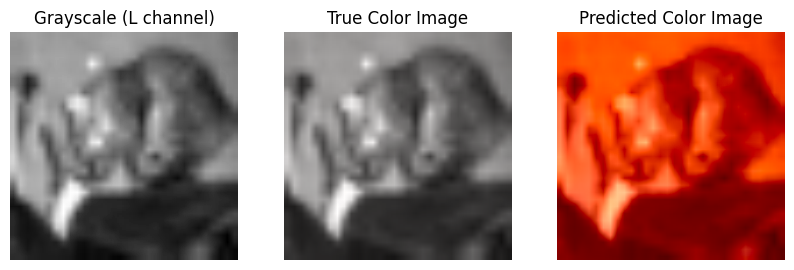

L channel shape: (224, 224)
True a channel shape: (224, 224)
True b channel shape: (224, 224)
Predicted a channel shape: (112, 112)
Predicted b channel shape: (112, 112)


<ipython-input-15-0d3d9e9a172b>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7915 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


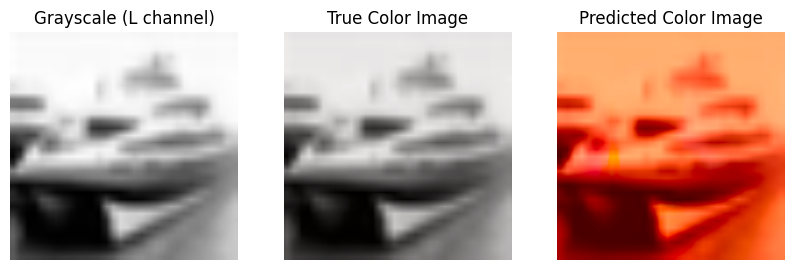

L channel shape: (224, 224)
True a channel shape: (224, 224)
True b channel shape: (224, 224)
Predicted a channel shape: (112, 112)
Predicted b channel shape: (112, 112)


<ipython-input-15-0d3d9e9a172b>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9420 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


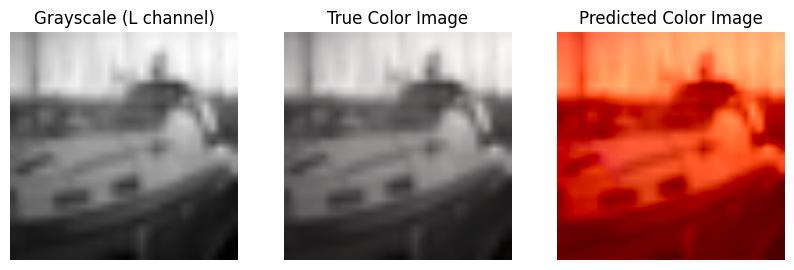

L channel shape: (224, 224)
True a channel shape: (224, 224)
True b channel shape: (224, 224)
Predicted a channel shape: (112, 112)
Predicted b channel shape: (112, 112)


<ipython-input-15-0d3d9e9a172b>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2089 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


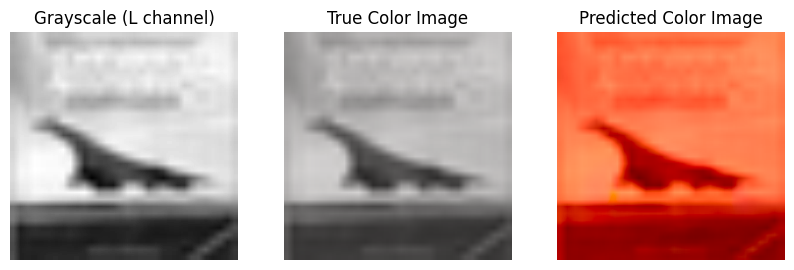

L channel shape: (224, 224)
True a channel shape: (224, 224)
True b channel shape: (224, 224)
Predicted a channel shape: (112, 112)
Predicted b channel shape: (112, 112)


<ipython-input-15-0d3d9e9a172b>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7822 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


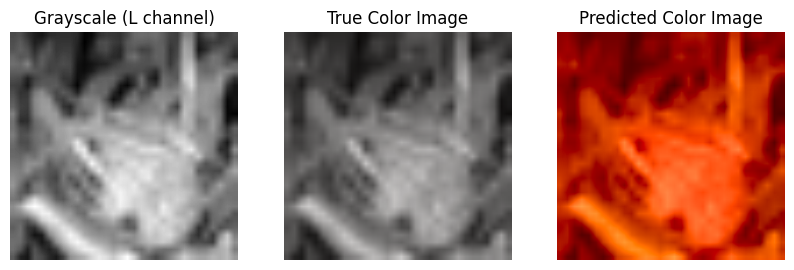

In [ ]:
visualize_test_cases(model, test_loader, num_samples=5)

In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
from lpips import LPIPS